# This is the test task of Sviatoslav Sheipak
(contact me via s.sheypak@gmail.com)

# Task 1.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
input_filename = 'task2.txt'
db = pd.read_csv(input_filename, sep='\t', header=None)
print(db.shape)
db.head()

(1000, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,0.155051,0.974187,0.074675,0.442146,0.369443,0.468138,0.578846,0.422744,0.931543,0.474148,15
1,0.968379,0.716820,0.678846,0.510049,0.545299,0.573692,0.817491,0.206636,0.880111,0.574187,17
2,0.468263,0.405603,0.320325,0.468084,0.100995,0.974407,0.300062,0.608356,0.050082,0.762011,12
3,0.776820,0.103740,0.373748,0.797782,0.906810,0.599069,0.626680,0.924705,0.632768,0.512663,16
4,0.407886,0.415357,0.101543,0.935160,0.444124,0.193607,0.656837,0.599929,0.868582,0.405406,20


### Split to train and test

In [3]:
seed = 42

In [4]:
Y = db[10].values
X = db.drop(columns=[10]).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

In [5]:
X_train.shape, X_test.shape

((900, 10), (100, 10))

### Train models
Here we have decided to experiment with linear models. This idea is based on the following facts:
- these are the simplest types of models
- they allow to examine feature importances
- there are not many data points

Here are 4 linear models with several kinds of regularizations. As we are facing a regression task in a very general form we will optimize MSE loss and use it as a criteria of models' effectivness.

In [6]:
model_lr = LinearRegression()
model_l2 = Ridge()
model_l1 = Lasso(alpha=0.001)
model_el = ElasticNet(alpha=0.001)

In [7]:
models_list = [model_lr, model_l2, model_l1, model_el]
models_names = ["LinearRegression", "Ridge", "Lasso", "ElasticNet"]
models_coefs = []
for model, model_name in zip(models_list, models_names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_score = mean_squared_error(Y_train, train_pred)
    test_score = mean_squared_error(Y_test, test_pred)
    print("{} train score: {:.3f}, test score: {:3.3f}".format(model_name, train_score, test_score))
    models_coefs.append(model.coef_)

LinearRegression train score: 5.814, test score: 6.916
Ridge train score: 5.817, test score: 6.931
Lasso train score: 5.814, test score: 6.913
ElasticNet train score: 5.815, test score: 6.921


As we can see, there is no significant difference in results. Let's examine the coefficients of these models to figure out what are the most important features.

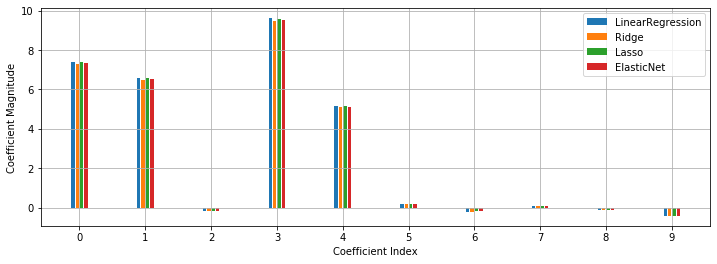

In [8]:
ncoef = len(models_coefs[0])
nmodels = len(models_list)
margins = np.linspace(-0.1, 0.1, nmodels)
default_x = np.arange(ncoef)
plt.figure(figsize=(12,4))
plt.grid()
for i in range(len(models_list)):
    coefs = models_coefs[i]
    plt.bar(margins[i] + default_x, coefs, label=models_names[i], width=0.05)
plt.xticks(default_x)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc='upper right')
plt.show()

Following the plot, we can conclude that the most important features are those with indexes `0, 1, 3, 4`. In order to express the importance with numbers from [0, 1] we could apply softmax to absolute values of these coefficients.

In [9]:
from scipy.special import softmax

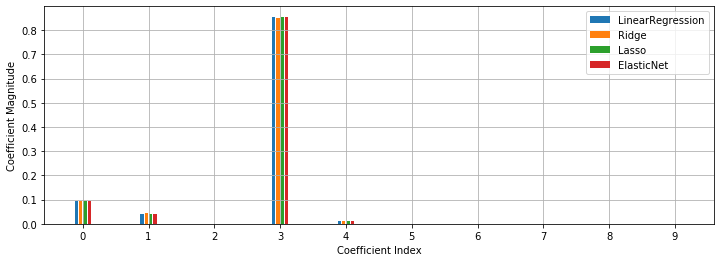

In [10]:
ncoef = len(models_coefs[0])
nmodels = len(models_list)
margins = np.linspace(-0.1, 0.1, nmodels)
default_x = np.arange(ncoef)
plt.figure(figsize=(12,4))
plt.grid()
for i in range(len(models_list)):
    coefs = models_coefs[i]
    plt.bar(margins[i] + default_x, softmax(abs(coefs)), label=models_names[i], width=0.05)
plt.xticks(default_x)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc='upper right')
plt.show()

However, it is not very descriptive.

Let's train a model on `0, 1, 3, 4` features only.

In [11]:
smaller_model = LinearRegression()
important_feature_idx = [0, 1, 3, 4]
smaller_model.fit(X_train[:,  important_feature_idx], Y_train)
train_pred = smaller_model.predict(X_train[:,  important_feature_idx])
test_pred = smaller_model.predict(X_test[:,  important_feature_idx])
train_score = mean_squared_error(Y_train, train_pred)
test_score = mean_squared_error(Y_test, test_pred)
print("{} train score: {:.3f}, test score: {:3.3f}".format('Smaller LR', train_score, test_score))

Smaller LR train score: 5.841, test score: 6.856


The result didn't change much, therefore it only proves that all other features are not very significant.
Now we switch to a slightly different method of feature importance investigation - one provided by random forest.

#### Random Forest Regressor and feature importance

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
forest = RandomForestRegressor(n_estimators=50, max_depth=4)
forest.fit(X_train, Y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)
train_score = mean_squared_error(Y_train, train_pred)
test_score = mean_squared_error(Y_test, test_pred)
print("{} train score: {:.3f}, test score: {:3.3f}".format('Forest Regressor', train_score, test_score))

Forest Regressor train score: 4.483, test score: 5.651


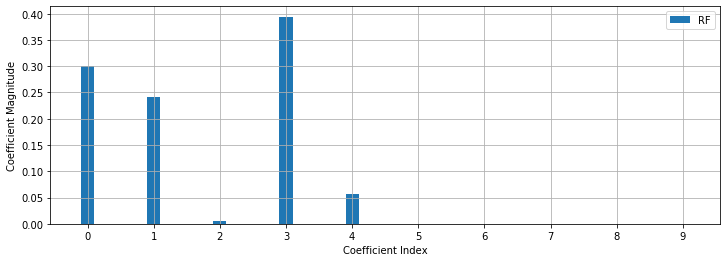

In [14]:
plt.figure(figsize=(12,4))
plt.grid()
plt.bar(default_x, forest.feature_importances_, label='RF', width=0.2)
plt.xticks(default_x)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc='upper right')
plt.show()

It drives us to the same conclusion - features `0, 1, 3, 4` are the relevant ones.

### Ways to improve
To improve these results we could use other methods:
- Recursive Feature Elimination (`from sklearn.feature_selection import RFE`)
- Statistical criterias (`from sklearn.feature_selection import SelectKBest`)
- Do PCA and examine variance matrix

Or we could ask about the origin of the data and meaning of these features and try to deduct their importances from business/common sence perspective.

# Task 2.
Here we are going to perform an algorithm of deduplication - a method that helps to find titles that describe same entities. Deduplication will be held in two steps:
- title normalization
- calculating distance between normed titles

Titles are considered to refer to the same entity if they are close.

In [15]:
import random
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

### Step 1. Normalization
We are going to apply quite simplie normalization tricks:
- lowercase
- remove whitespaces to convert `0.5 l` to `0.5l`. It will help to consider weights and volumes as one token
- normalize decimals delimeter: `0,25g` -> `0.25g`
- remove commas
- tokenize - split by whitespaces, the tokens are words
- remove stopwords
- stem words
- sort words; although it won't affect the distance calculation, it would be nice to have a standart word order in a normalized form
- join tokens with a single whitespace

In [16]:
rus_stopwords = set(stopwords.words('russian'))
rus_stopwords.remove('уже') # for the sake of Уже Готово
rus_stemmer = SnowballStemmer('russian')

In [17]:
def preprocess_title(title):
    res = title.lower()
    res = re.sub(r'([0-9]+)\s+(g|kg|l|ml|л|г|грамм|кг|килограмм|литр|литров)\b', '\\1\\2', res)
    res = re.sub(r'([0-9]+),([0-9]+\w*)\b', '\\1.\\2', res)
    res = re.sub(r',', '', res)
    return res

def tokenize_title(title, swords, stemmer=None):
    res = preprocess_title(title)
    # res = word_tokenize(res, 'russian')
    res = res.split()
    res = [word for word in res if word not in swords]
    if stemmer != None:
        res = [stemmer.stem(word) for word in res]
    return res

def normalize_title(title, swords, stemmer=None):
    tokens = tokenize_title(title, swords, stemmer)
    return ' '.join(sorted(tokens))

In [18]:
x = 'Салат Коул-Слоу постный, Уже Готово , 200 г'
normalize_title(x, rus_stopwords, rus_stemmer)

'200г готов коул-сло постн салат уж'

### Step 2. The distance
We are going to use the `fuzzywuzzy` module to calculate Levenshtein distance between tokens in normalized form. 
The thing we are going to imply - similarity in groups of titles that represent the same is much higher than between members of different groups.

In [19]:
# ! pip3 install python-Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [20]:
x = 'Салат Коул-Слоу постный, Уже Готово , 200 г'
y = 'Салат Коул Слоу упак'
fuzz.token_set_ratio(
    normalize_title(x, rus_stopwords, rus_stemmer),
    normalize_title(y, rus_stopwords, rus_stemmer)
)

85

Quite close. Let's see what happens to titles from the email

In [21]:
testcases = [
    'Кисломолочный напиток Актимель ежевично-черничный 100 г',
    'Напиток Данон Актимель черника/ежевика 2,5% 6*0,1л Россия',
    'Гель для душа Роскошная мягкость Черная орхидея Palmolive, 250 мл',
    'Гель Palmolive Naturals д/душа Роскошная мягкость Черная орхидея 250мл Италия',
    'Гель для душа Palmolive "Черная орхидея" 250 мл',
    'Корм Whiskas говядина/кролик канапе новогодний 85г Россия'    
]

In [22]:
normed_testcases = [normalize_title(x, rus_stopwords, rus_stemmer) for x in testcases]

In [23]:
similarity_matrix = np.zeros((len(testcases), len(testcases)))

In [24]:
for i, x in enumerate(normed_testcases):
    for j, y in enumerate(normed_testcases):
        similarity_matrix[i, j] = fuzz.token_set_ratio(x, y)

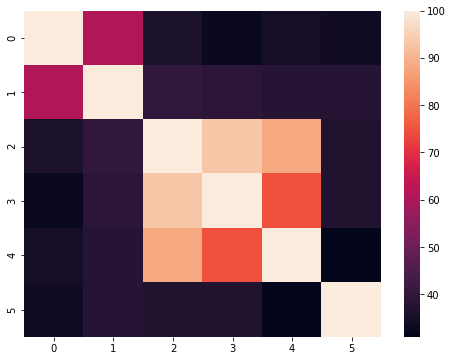

In [25]:
import seaborn as sn
plt.figure(figsize=(8,6))
sn.heatmap(similarity_matrix)
plt.show()

As we see from from diagonal blocks the result is correct: `[[1, 2], [3, 4, 5], [6]]`.

Let's obtain this grouping explicitly: 
- for each title we calculate average similarity with for every group that already exists
- take the score of the most similar group: 
    - if the score is more than a threshold, we add this title to this group
    - else this titles starts its own group
    
Theoretically we could adjust a thold, but since we don't have training data we'll use 50 - the middle of the scale.

In [26]:
 def group_normed_titles(normed_titles, thold=50):
    res = []
    for title in normed_titles:
        if not len(res):
            res.append([title])
            continue
        group_scores = []
        for i, group in enumerate(res):
            group_scores.append(np.mean([fuzz.token_set_ratio(title, x) for x in group]))
        argmax = np.argmax(group_scores)
        max_score = group_scores[argmax]
        if max_score < thold:
            res.append([title])
        else:
            res[argmax].append(title)
    return res

In [27]:
group_normed_titles(normed_testcases)

[['100г актимел ежевично-черничн кисломолочн напиток',
  '2.5% 6*0.1л актимел данон напиток росс черника/ежевик'],
 ['250 palmolive гел душ мл мягкост орхиде роскошн черн',
  '250мл naturals palmolive гел д/душ итал мягкост орхиде роскошн черн',
  '"черн 250 palmolive гел душ мл орхидея"'],
 ['85г whiskas говядина/кролик канап корм новогодн росс']]

Now we see the desired result. Good. Let's move to next and final part.

## Validation on full data

In [28]:
with open('test_task_NLP.json') as json_file:
    data = json.load(json_file)

#### Here we will plot some statistics - sizes of groups and most common tokens (before and after normalization)

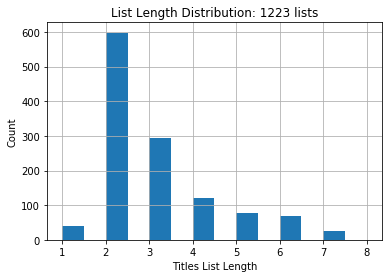

In [29]:
lengths = list(map(len, data))
x_axis = np.arange(1, max(lengths) + 2)
plt.hist(lengths, width=0.5, bins=x_axis)
plt.grid()
plt.xticks(x_axis)
plt.xlabel('Titles List Length')
plt.ylabel('Count')
plt.title('List Length Distribution: {} lists'.format(len(data)))
plt.show()

In [30]:
sum(lengths)

3580

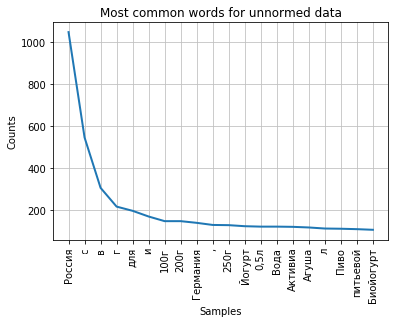

In [31]:
merged_data = sum(data, [])
merged_data = sum([title.split() for title in merged_data], [])
freq = nltk.FreqDist(merged_data)
plt.title('Most common words for unnormed data')
freq.plot(20, cumulative=False)
plt.show()

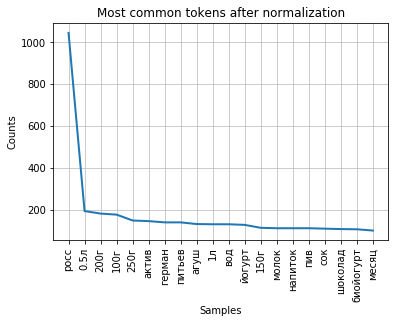

In [32]:
processed_titles = sum([tokenize_title(x, rus_stopwords, rus_stemmer) for x in sum(data, [])], [])
freq = nltk.FreqDist(processed_titles)
plt.title('Most common tokens after normalization')
freq.plot(20, cumulative=False)
plt.show()

We are going to estimate ingroup and outgroup similarities.

For ingroups we will implement a straighforward calculation for every pair in a group. 
As for outgroup similarity to decrease computational costs we will use **negative sampling** - for each title we will sample 10 other titles and calculate similarities with those, that do not belong to the same group as the target title.

In [33]:
preprocessed_data = []
for i, group in enumerate(data):
    for title in group:
        normed_title = ' '.join(tokenize_title(title, rus_stopwords, rus_stemmer))
        preprocessed_data.append([normed_title, i])

In [34]:
ingroup_distance = []
for group in data:
    for i, x in enumerate(group):
        for y in group[i+1:]:
            ingroup_distance.append(
                fuzz.token_set_ratio(
                    ' '.join(tokenize_title(x, rus_stopwords, rus_stemmer)),
                    ' '.join(tokenize_title(y, rus_stopwords, rus_stemmer))
                )
            )

In [35]:
outgroup_distance = []
for x in preprocessed_data:
    for y in random.sample(preprocessed_data, 10):
        if x[1] != y[1]:
            outgroup_distance.append(fuzz.token_set_ratio(x[0], y[0]))

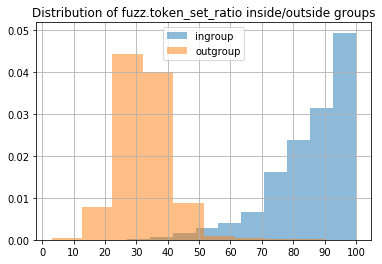

In [36]:
plt.title('Distribution of fuzz.token_set_ratio inside/outside groups')
plt.hist(ingroup_distance, label='ingroup', alpha=0.5, density=True)
plt.hist(outgroup_distance, label='outgroup', alpha=0.5, density=True)
plt.legend(loc=0)
plt.grid()
plt.xticks(np.arange(0, 110, 10))
plt.show()

This plot proves our point about ingroup and outgroup similarities and suggests that our approach was valid. However, there is still space to improve, as we see the overlapping parts of distributions.